In [1]:
#coding=utf-8
# standard library
import gc
import importlib
import os
import sys
import pickle
import socket
import statistics
import struct
import time
from datetime import datetime

# pip3 library
import psutil
import scipy
import tqdm
import numpy as np
import pandas as pd
import sklearn.cluster as cluster
import xgboost as xgb

# custom functions
import matplotlib.pyplot as plt
import gan_func
importlib.reload(gan_func)  # For reloading after making changes
from gan_func import *
plt.style.use('ggplot')     # select plt style

Using TensorFlow backend.


-------------------------
Check memory
[472806289408, 410700980224]
[472806289408, 410727436288]
-------------------------
Load Dataset
size       186.997503
times    13559.194798
dtype: float64 size      242.706800
times    7678.275855
dtype: float64
   count
0  13728
1  10302
Data preprocessing finish
Start to setting GAN


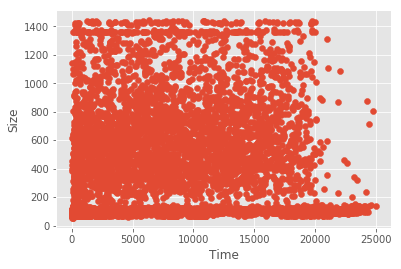

In [2]:
# collect trash and check memory
check_memory()

server_ip = '192.168.1.133'
client_ip = '124.123.243.15'

# Load engineered dataset from EDA section

#data = pd.read_csv('../skype_eth_5.csv')
print('Load Dataset')
label_cols = ['Class']

'''
# different src ip addr && dst ip addr
mask1 = data['src'] == server_ip
mask2 = data['src'] == client_ip
dataSample = data.loc[(mask1 | mask2)]
mask3 = dataSample['dst'] == client_ip
mask4 = dataSample['dst'] == server_ip
dataSample = dataSample.loc[(mask3 | mask4)]
# dataSample = data.loc[data['dst'] == server_ip]
dataSample['time'] = dataSample['time'].apply(check_time_format)
dataSample['date'] = dataSample['date'].apply(lambda x: x.replace('-', ' '))
dataSample['times'] = dataSample['date'] + ' ' + dataSample['time']
dataSample['times'] = dataSample['times'].apply(lambda x: datetime.strptime(x, '%Y %m %d %H:%M:%S.%f').timestamp())
dataSample['times'] = dataSample['times'].apply(lambda x: float(str(x)[6:]) * 1e6) # x[0:5] in timestamp are all the same

# calculate relative value
prev_times = 0
for index, row in dataSample.iterrows():
    dataSample.at[index, 'size'] = float(row['size'])
    original_val = row['times']
    new_val = original_val - prev_times
    prev_times = row['times']
    dataSample.at[index, 'times'] = new_val

# filter src && dst
dataSample = dataSample.loc[dataSample['src'] == server_ip]
dataSample = dataSample.loc[dataSample['dst'] == client_ip]

# remove times
dataSample.drop(dataSample[dataSample.times > 25000].index, inplace=True)
dataSample.drop(dataSample[dataSample.times < 0].index, inplace=True)

# remove unused column
dataSample.drop('date', axis=1, inplace=True)
dataSample.drop('src', axis=1, inplace=True)
dataSample.drop('dst', axis=1, inplace=True)
dataSample.drop('time', axis=1, inplace=True)
dataSample.drop('number', axis=1, inplace=True)
dataSample.drop('clean_size', axis=1, inplace=True)

# save traffic

#dataSample.to_csv('server_traffic.csv')
'''
dataSample = pd.read_csv('server_traffic.csv')
dataSample = dataSample[['size', 'times']]
dataSample_o = pd.read_csv('../client/client_traffic.csv')
dataSample_o = dataSample_o[['size', 'times']]

normalized_dataSample = (dataSample - dataSample.mean()) / dataSample.std()                     # Zero-mean normalization  
normalized_dataSample_o = (dataSample_o - dataSample_o.mean()) / dataSample_o.std()
# normalized_dataSample = (dataSample - dataSample.min()) / (dataSample.max() - dataSample.min()) # Min-max normalization
data_cols = ['times', 'size']
print(dataSample.mean(), dataSample.std())

# Add KMeans generated classes to fraud data - see classification section for more details on this
train = normalized_dataSample.copy()
train_o = normalized_dataSample_o.copy()

labels = cluster.KMeans(n_clusters=2, random_state=0).fit_predict(train[data_cols])
print(pd.DataFrame([[np.sum(labels == i)] for i in np.unique(labels)], columns=['count'], index=np.unique(labels)))
print('Data preprocessing finish')

# Generate arguments and training the GAN and WGAN architectures, WGAN are use WGAN-GP
print('Start to setting GAN')
fraud_w_classes = train.copy()

# print the original data figure
origin = dataSample.values.copy()
x2 = origin[:, 1]
y2 = origin[:, 0]
plt.scatter(x2, y2)
plt.xlabel('Time')
plt.ylabel('Size')
plt.show()

In [1]:
#%%time
# Arguments
rand_dim = 32                       # needs to be ~data_dim
base_n_count = 128
nb_steps = 25000 + 1                # Add one for logging of the last interval
batch_size = 64
k_d = 5                             # number of critic network updates per adversarial training step
k_g = 1                             # number of generator network updates per adversarial training step
critic_pre_train_steps = 100        # number of steps to pre-train the critic before starting adversarial training
log_interval = 100                  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
learning_rate = 1e-4                # WGAN: 5e-5, WGAN-GP: 1e-4, CGAN: 2e-4
data_dir = 'cache/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)              # check dir is exist
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

show = True                        # choose whether to show the traing img

random_subset = fraud_w_classes.copy().reset_index(drop=True)                               # fraud only with labels from classification, reset the index
arguments = [rand_dim, nb_steps, batch_size, k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
             data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show]
arguments[1] = 25001
arguments[2] = 64

# Four GANs
# adversarial_training_GAN(arguments, random_subset, data_cols=data_cols)                             # GAN
# adversarial_training_WGAN(arguments, train, data_cols=data_cols)                                    # WGAN
# adversarial_training_InfoGAN(arguments, train, data_cols=data_cols)                                 # InfoGAN
# adversarial_training_GAN(arguments, random_subset, data_cols=data_cols, label_cols=label_cols)      # CGAN
adversarial_training_WGAN(arguments, train, train_o, data_cols=data_cols, label_cols=label_cols)             # WCGAN
print('Finish training GAN')

NameError: name 'os' is not defined

In [4]:
# Let's look at some of the generated data
# First create the networks locally and load the weights
print('Create networks')
seed = 17
data_dim = len(data_cols)
label_dim = len(label_cols)
with_class = True if label_dim > 0 else False
# with_class = False
np.random.seed(seed)

# Define four network models
# with class
generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
generator_model.load_weights('cache/WCGAN_generator_model_weights_step_' + str(nb_steps - 1) + '.h5')
# generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count)
# generator_model.load_weights('cache/CGAN_generator_model_weights_step_' + str(nb_steps - 1) + '.h5')

# with_class = False
# train = train_no_label
# label_cols = []
# generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count, type='Wasserstein')
# generator_model.load_weights('cache/WGAN_generator_model_weights_step_' + str(nb_steps - 1) + '.h5')
# generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count)
# generator_model.load_weights('cache/GAN_generator_model_weights_step_' + str(nb_steps - 1) + '.h5')
# generator_model, discriminator_model, combined_model = define_models_InfoGAN(rand_dim, data_dim, base_n_count)
# generator_model.load_weights('cache/InfoGAN_generator_model_weights_step_' + str(nb_steps - 1) + '.h5')
print('-------------------------')


Create networks
-------------------------


Generate new data and result


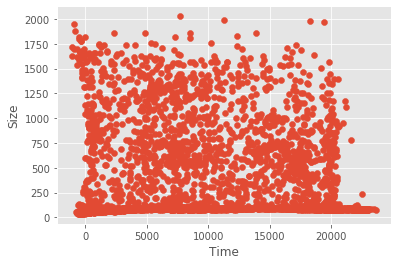

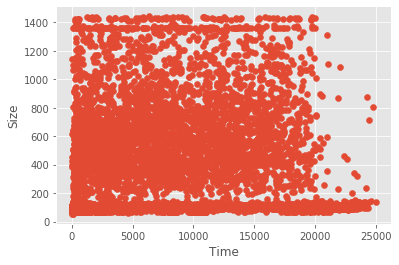

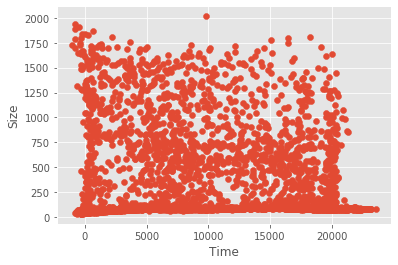

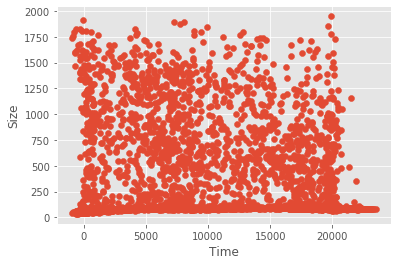

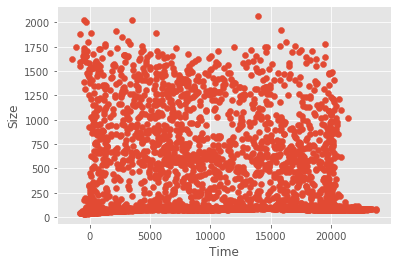

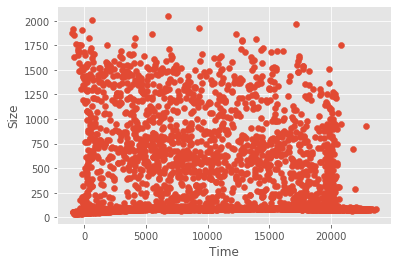

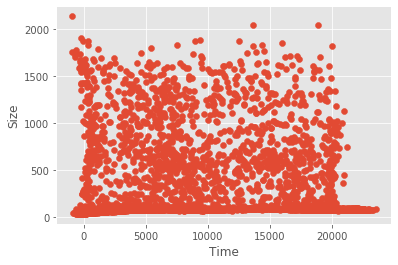

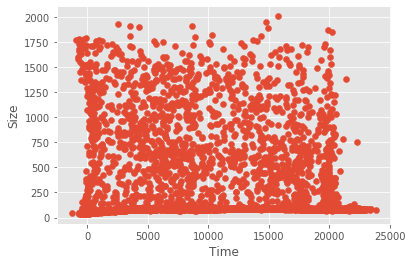

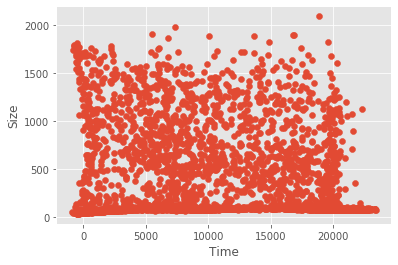

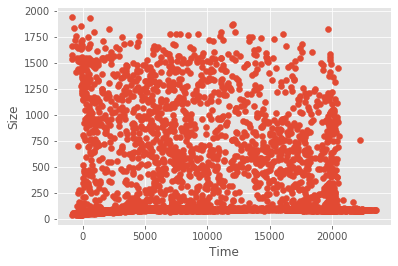

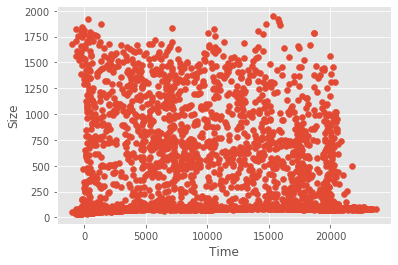

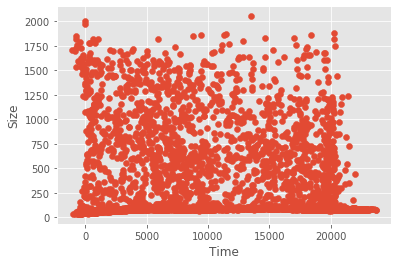

-------------------------


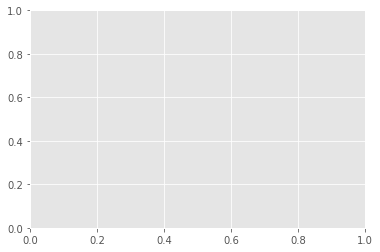

In [5]:
# Now generate some new data
print('Generate new data and result')
test_size = int(dataSample.values.shape[0] / 3)             # Equal to all of the fraud cases, dataSample: 1554, test_size: 518

# generate some data and use generator to get result
x = get_data_batch(train, test_size, seed=seed)
z = np.random.normal(size=(test_size, rand_dim))
if with_class:
    labels = x[:, -label_dim:]
    g_z = generator_model.predict([z, labels])
else:
    g_z = generator_model.predict(z)

# denormailize the generator's result
result = g_z.copy()
# print(labels)
# print(result)
result[:, 0] *= dataSample.std()[0]
result[:, 0] += dataSample.mean()[0]

result[:, 1] *= dataSample.std()[1]
result[:, 1] += dataSample.mean()[1]

b = result[:, 0].astype('int').reshape(-1, 1)
c = result[:, 1].astype('float64').reshape(-1, 1)
result = np.concatenate((b, c), axis=1)

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.6f}'.format}) # setting print floating point numbers, and print format

x1 = result[:, 1]
y1 = result[:, 0]

# Remove maxima value
# for i in list(np.where(y1 > 95)):
#     x1 = np.delete(x1, i)
#     y1 = np.delete(y1, i)

# print the generator data pic
plt.scatter(x1, y1)
plt.xlabel('Time')
plt.ylabel('Size')
save_name = data_dir + 'generator_fig' + '.png'
plt.savefig(save_name)
plt.show()
plt.cla()

# print the original data figure
origin = dataSample.values.copy()
x2 = origin[:, 1]
y2 = origin[:, 0]
plt.scatter(x2, y2)
plt.xlabel('Time')
plt.ylabel('Size')
save_name = data_dir + 'original_fig' + '.png'
plt.savefig(save_name)
plt.show()
plt.cla()

# show_info(x1, y1)
# show_info(x2, y2)

# generate some data and use generator to get result
# run 10 times to generate data and result
for i in range(10):
    np.random.seed(i)
    z = np.random.normal(size=(test_size, rand_dim))
    if with_class:
        labels = x[:,-label_dim:]
        g_z = generator_model.predict([z, labels])
    else:
        g_z = generator_model.predict(z)

    # denormailize the generator's result
    result = g_z.copy()
    result[:, 0] *= dataSample.std()[0]
    result[:, 0] += dataSample.mean()[0]

    result[:, 1] *= dataSample.std()[1]
    result[:, 1] += dataSample.mean()[1]

    b = result[:, 0].astype('int').reshape(-1, 1)
    c = result[:, 1].astype('float64').reshape(-1, 1)

    result = np.concatenate((b, c), axis=1)

    x1 = result[:, 1]
    y1 = result[:, 0]
    '''
    for i in list(np.where(x1 < 5800)):
        y1 = np.delete(y1, i)
        x1 = np.delete(x1, i)
    '''
#     for j in list(np.where(y1 > 95)):
#         y1 = np.delete(y1, j)
#         x1 = np.delete(x1, j)

    # print the generate data figure
    plt.scatter(x1, y1)
    plt.xlabel('Time')
    plt.ylabel('Size')
    save_name = data_dir + 'result_' + str(i + 1) + '_fig' + '.png'
    plt.savefig(save_name)
    plt.show()
    plt.cla()
print('-------------------------')

Load model
Find best xgb scores overall and saved
WCGAN step 7050: 0.6100
WCGAN step 11200: 0.6197

Look at the unsmoothed losses
0


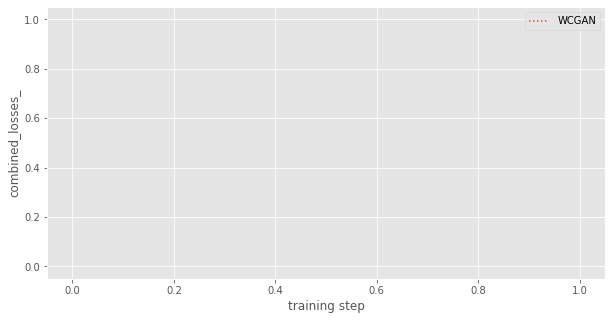

0


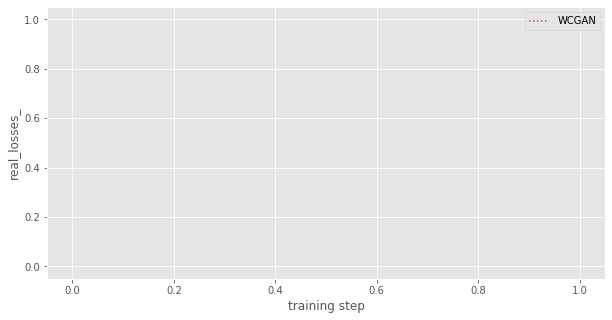

0


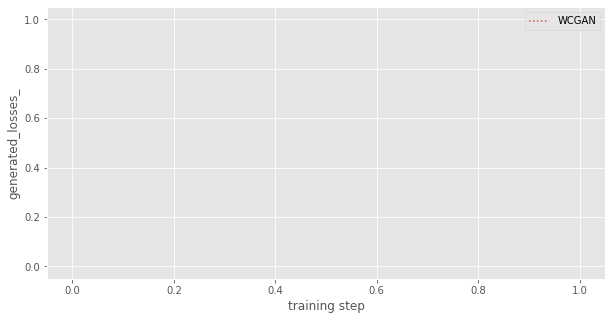

0


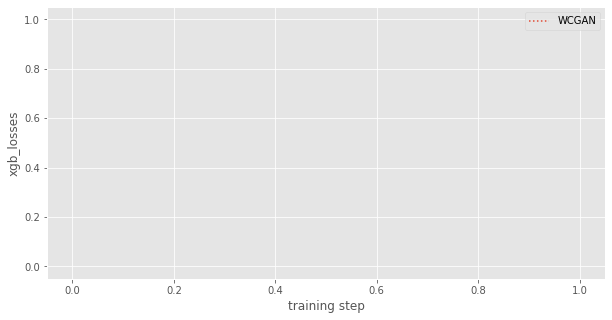

100


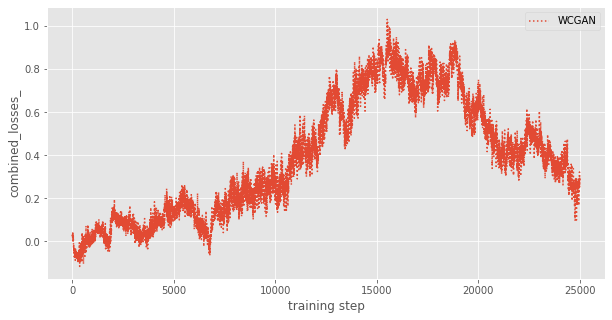

100


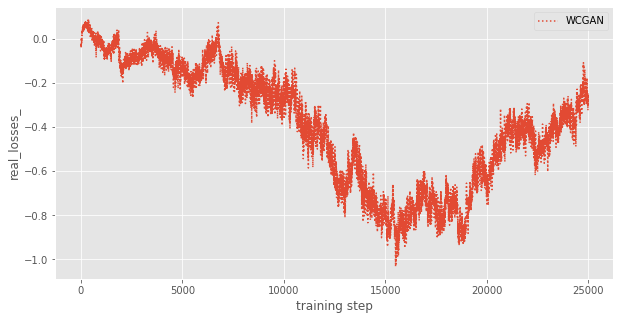

100


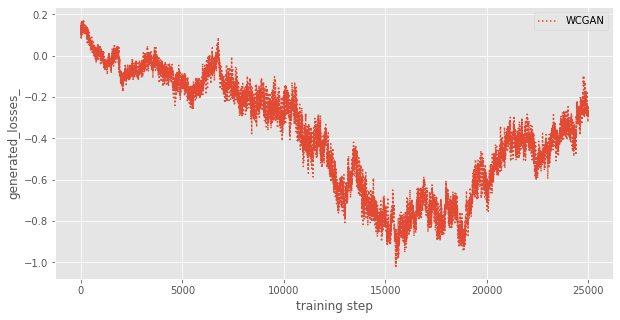

100


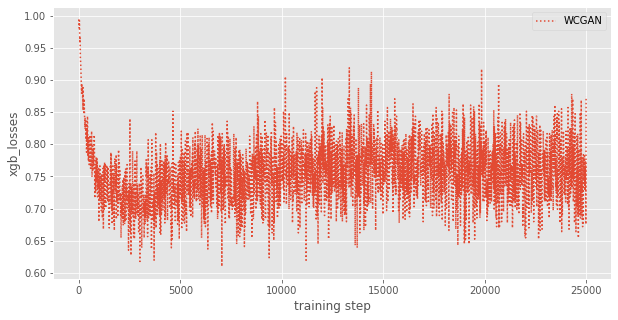

In [6]:
import gan_func
importlib.reload(gan_func)  # For reloading after making changes
from gan_func import *
# load model
print('Load model')
base_dir = 'cache/'
suffix = '_step_' + str(nb_steps - 1)

# separate be combined_loss, disc_loss_real, disc_loss_generated, xgb_losses
# GAN_losses = pickle.load(open(base_dir + 'GAN_losses' + suffix + '.pkl', 'rb'))
# CGAN_losses = pickle.load(open(base_dir + 'CGAN_losses' + suffix + '.pkl', 'rb'))
# WGAN_losses = pickle.load(open(base_dir + 'WGAN_losses' + suffix + '.pkl', 'rb'))
WCGAN_losses = pickle.load(open(base_dir + 'WCGAN_losses' + suffix + '.pkl', 'rb'))

# linestyles = ['-', '--', '-.', ':']
losses = WCGAN_losses
label = 'WCGAN'
linestyle = ':'

# Find best xgb scores overall and saved (every 100 steps)
print('Find best xgb scores overall and saved')

data_ix = 3
# data_sets = [GAN_losses[data_ix], CGAN_losses[data_ix], WGAN_losses[data_ix], WCGAN_losses[data_ix]]
# labels = ['GAN', 'CGAN', 'WGAN', 'WCGAN']
data_set = losses[data_ix]

best_step = list(data_set).index(np.array(data_set).min()) * 10
print('{: <5} step {: <4}: {:.4f}'.format(label, best_step, np.array(data_set).min()))

xgb100 = [data_set[i] for i in range(0, len(data_set), 10)]
best_step = xgb100.index(min(xgb100)) * 100
print('{: <5} step {: <4}: {:.4f}\n'.format(label, best_step, np.array(xgb100).min()))
# print(best_step, min(xgb100))


# Look at the unsmoothed losses
print('Look at the unsmoothed losses')
unsmoothed_losses(losses, label, linestyle)
unsmoothed_losses(losses, label, linestyle, 100)

Create a figure for the critic losses for the WGAN


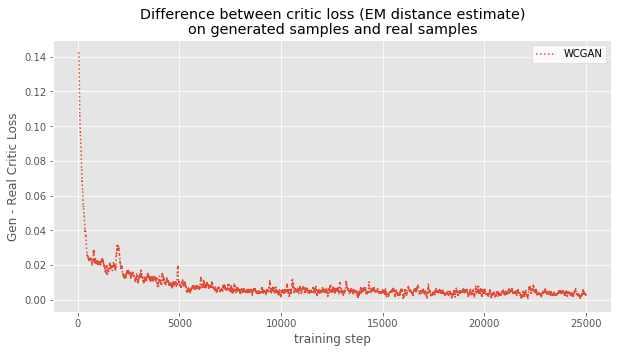

In [7]:
# Create a figure for the critic losses for the WGAN and WCGAN
print('Create a figure for the critic losses for the WGAN')
w = 50       # Size of the moving window. This is the number of observations used for calculating the statistic.
data_ix0 = 2 # generated_losses_
data_ix1 = 1 # real_losses_
# data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_', 'xgb_losses']

# labels = ['GAN','CGAN','WGAN','WCGAN'][1:3]
# data_sets0 = [GAN_losses[data_ix0], CGAN_losses[data_ix0], WGAN_losses[data_ix0], WCGAN_losses[data_ix0]][1:3]
# data_sets1 = [GAN_losses[data_ix1], CGAN_losses[data_ix1], WGAN_losses[data_ix1], WCGAN_losses[data_ix1]][1:3]
# linestyles = ['-', '--', '-.', ':'][1:3]

plt.figure(figsize=(10, 5))
data0 = losses[data_ix0]
data1 = losses[data_ix1]
plt.plot(range(0, len(data0)), pd.DataFrame(np.array(data0) - np.array(data1)).rolling(w).mean(), label=label, linestyle=linestyle)
plt.title('Difference between critic loss (EM distance estimate)\non generated samples and real samples')
plt.xlabel('training step')
plt.ylabel('Gen - Real Critic Loss')
legend = plt.legend() 
legend.get_frame().set_facecolor('white')
plt.savefig('cache/Delta_critic_loss_plot.png')

# save result
np.savetxt('result.txt', result, newline='\n', fmt='%0.2f')